## Generating edges

In [1]:
import pandas as pd
import json

# load the data from your JSON fil
with open(r'C:\Users\91787\PycharmProjects\autoscious-carbon-capture\data_collection\output_100.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
0  17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33   
1  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
2  a4830bc41a88ee369f08c0556360c12cf887f564   
3  ecacc2f192e4b881ca95749821b9d8595a81477b   
4  9a722f9ec3bca95b5f86b501706d040dc968472d   

                                                 url  \
0  https://www.semanticscholar.org/paper/17a3eb5c...   
1  https://www.semanticscholar.org/paper/f15a2d21...   
2  https://www.semanticscholar.org/paper/a4830bc4...   
3  https://www.semanticscholar.org/paper/ecacc2f1...   
4  https://www.semanticscholar.org/paper/9a722f9e...   

                                               title  \
0  Carbon capture and storage at the end of a los...   
1  Renewable-integrated flexible carbon capture: ...   
2  Recent advances in carbon capture storage and ...   
3                         Atmospheric Carbon Capture   
4  Carbon mineralization pathways for carbon capt...   

                                           

In [2]:
df['citations']

0     [{'paperId': '0fbc075056e6f013959529ebd322e9c7...
1     [{'paperId': '0fbc075056e6f013959529ebd322e9c7...
2     [{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...
3                                                    []
4     [{'paperId': 'cdf54c05ca1e314605992c5639c28a45...
                            ...                        
95    [{'paperId': '4c406a3948cbf93bcab5b527ce94e081...
96    [{'paperId': 'e59cddc8e2c115a5b1c23eef8a268abf...
97    [{'paperId': '5b955378f0c9404f62bd54ba8cba481f...
98    [{'paperId': '24fc912e70c7e31a480c7172b89e21b2...
99    [{'paperId': '34f40bd465b71ea5cd21f2cfeffeacb5...
Name: citations, Length: 100, dtype: object

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler
import json


In [4]:
# Get embedding distances

# Extract 'vector' from 'embedding' and convert to DataFrame
embedding_df = pd.DataFrame(df['embedding'].apply(lambda x: x['vector']).tolist())

# Compute the cosine distances
distances = cosine_distances(embedding_df)

# Initialize a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Reshape distances to a 1D array and scale
distances_scaled = scaler.fit_transform(distances.reshape(-1, 1))

# Reshape back to original shape
distances_scaled = distances_scaled.reshape(distances.shape)


In [5]:
# Initialize lists to store the edges data
source = []
target = []
weights = []

# Iterate over the distances matrix
for i in range(distances.shape[0]):
    for j in range(i+1, distances.shape[1]):  # j starts from i+1 to avoid duplicate edges and self-edges
        source.append(df.iloc[i]['paperId'])
        target.append(df.iloc[j]['paperId'])
        weights.append(distances_scaled[i, j])

# Create the edges DataFrame
edges_df = pd.DataFrame({'ID': range(len(source)), 'Weight': weights, 'Source': source, 'Target': target})


In [6]:
# Convert the DataFrame to a JSON string
edges_json = edges_df.to_json(orient='records', indent=4)

# Dump in JSON
with open('edges.json', 'w') as f:
    json.dump(edges_json, f, indent=2)

# Convert the JSON string to a dictionary
edges_dict = json.loads(edges_json)


## Generating topics / themes from GPT3.5

In [7]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\91787\PycharmProjects\autoscious-carbon-capture\data_collection\output_100.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
0  17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33   
1  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
2  a4830bc41a88ee369f08c0556360c12cf887f564   
3  ecacc2f192e4b881ca95749821b9d8595a81477b   
4  9a722f9ec3bca95b5f86b501706d040dc968472d   

                                                 url  \
0  https://www.semanticscholar.org/paper/17a3eb5c...   
1  https://www.semanticscholar.org/paper/f15a2d21...   
2  https://www.semanticscholar.org/paper/a4830bc4...   
3  https://www.semanticscholar.org/paper/ecacc2f1...   
4  https://www.semanticscholar.org/paper/9a722f9e...   

                                               title  \
0  Carbon capture and storage at the end of a los...   
1  Renewable-integrated flexible carbon capture: ...   
2  Recent advances in carbon capture storage and ...   
3                         Atmospheric Carbon Capture   
4  Carbon mineralization pathways for carbon capt...   

                                           

In [8]:
from dotenv import load_dotenv

import os
load_dotenv()
os.getenv("OPENAI_API_KEY")


ModuleNotFoundError: No module named 'dotenv'

In [14]:
# imports
from dotenv import load_dotenv


load_dotenv()
import os
# openai_api_key = os.getenv('OPENAI_API_KEY')
import openai
openai_api_key = os.getenv('OPENAI_API_KEY')

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
# GPT_MODEL = "gpt-4"

# for bulk openai message, no stream
def chat_openai(prompt="Tell me to ask you a prompt", chat_history=[]):
    # define message conversation for model
    if chat_history:
        messages = chat_history
    else:
        messages = [
            {"role": "system", "content": "You are ChatGPT, a large language model trained by OpenAI. Answer as concisely as possible."},
        ]
    messages.append({"role": "user", "content": prompt})

    # create the chat completion
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0
    )
    text_answer = completion["choices"][0]["message"]["content"]

    # updated conversation history
    messages.append({"role": "assistant", "content": text_answer})

    return text_answer, messages

In [13]:
!pip install openai


  Using cached openai-0.27.8-py3-none-any.whl (73 kB)
     ------------------------------------ 319.8/319.8 kB 992.3 kB/s eta 0:00:00
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 0:00:00


In [15]:
df.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references
0,17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33,https://www.semanticscholar.org/paper/17a3eb5c...,Carbon capture and storage at the end of a los...,None,2021,51,True,None,"[{'category': 'Engineering', 'source': 's2-fos...","{'model': 'specter@v0.1.1', 'vector': [-0.3693...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '979676198e622a6c39daefcb08f88c94...
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...
2,a4830bc41a88ee369f08c0556360c12cf887f564,https://www.semanticscholar.org/paper/a4830bc4...,Recent advances in carbon capture storage and ...,None,2020,206,True,[Materials Science],"[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [4.65861...",None,[{'paperId': '41fb6867c18f3e3a8ca70e8ce9388c51...,[{'paperId': '965050bb8475801dfcfd49509a529aa1...
3,ecacc2f192e4b881ca95749821b9d8595a81477b,https://www.semanticscholar.org/paper/ecacc2f1...,Atmospheric Carbon Capture,None,2022,0,False,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.25967...",None,[],[]
4,9a722f9ec3bca95b5f86b501706d040dc968472d,https://www.semanticscholar.org/paper/9a722f9e...,Carbon mineralization pathways for carbon capt...,None,2021,28,True,[Medicine],"[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [3.95449...",None,[{'paperId': 'cdf54c05ca1e314605992c5639c28a45...,[{'paperId': '9c96e28b7a2e5a312b203df19a8a515d...


In [163]:
# existing_themes = 'Renewable integration, carbon capture, Clean energy transition, Operational flexibility, Cost-effective CO2 reduction, carbon storage, lost decade'

# paper = "titled '" + df.iloc[0]["title"] + "'"
# if df.iloc[0]["abstract"]:
#     paper += "with the following abstract: " + df.iloc[0]["abstract"]

# prompt = f'''
# Paper: {paper} \n Task: Given the paper title and abstract above, determine at most 5 themes for a researcher whose goal is to eventually make impactful discoveries and experiments. \n Rules: Do not output any theme that is beyond what is given in the paper. Be as concise (less than 5 words), clear, and correct as possible. Do not make up anything not apparent from the paper. \n Use themes from other papers only if the paper mentions them: {existing_themes}. 

# Your output should be of the following format: Theme1, Theme2, Theme3, Theme4, Theme5
# '''

In [16]:
# Test 2 following some guy's topic modeling article: https://medium.com/@stephensonebinezer/transform-your-topic-modeling-with-chatgpt-cutting-edge-nlp-f4654b4eac99

existing_themes = set()

df['title_abstract'] = df.apply(lambda row: "Title: " + row["title"] + ("; Abstract: " + row["abstract"] if pd.notnull(row["abstract"]) else ""), axis=1)

In [17]:
df_sorted = df.sort_values(by='citationCount', ascending=False)
df_sorted.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,title_abstract
47,e02f812df3cd677ec931b0ce47e10640f16968fa,https://www.semanticscholar.org/paper/e02f812d...,Carbon dioxide capture in metal-organic framew...,"Kenji Sumida, David L. Rogow, Jarad A. Mason, ...",2012,5135,False,"[Chemistry, Medicine]","[{'category': 'Chemistry', 'source': 'external...","{'model': 'specter@v0.1.1', 'vector': [3.49991...","{'model': 'tldr@v2.0.0', 'text': None}",[{'paperId': '34f66f10e82255919a8ef3ce4253edd7...,[{'paperId': 'ce9de99ebb52218258ac835970bbeb32...,Title: Carbon dioxide capture in metal-organic...
30,e1e15aa932ac61efa8bb0c5cc99cfe6521458861,https://www.semanticscholar.org/paper/e1e15aa9...,Carbon capture and storage update,"In recent years, Carbon Capture and Storage (S...",2014,1554,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [1.57255...",None,[{'paperId': '2ea2ca8cf40d415e90f44a55526dc70e...,[{'paperId': '55ab0437932de9aa220ceb45025fbe77...,Title: Carbon capture and storage update; Abst...
74,b6bb06636648402dc393342720768317f8e6ff8e,https://www.semanticscholar.org/paper/b6bb0663...,"Carbon capture, storage and utilisation techno...",None,2015,982,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [0.22589...",None,[{'paperId': 'ac1e0a1f302088804a573900174dac30...,[{'paperId': 'ac0db1a69677f4c2beabee70a8908cd8...,"Title: Carbon capture, storage and utilisation..."
5,5b190c555003e154bb9038844899014425236273,https://www.semanticscholar.org/paper/5b190c55...,Carbon capture and conversion using metal-orga...,Rapidly increasing atmospheric CO2 concentrati...,2019,802,False,"[Materials Science, Medicine]","[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [1.39446...","{'model': 'tldr@v2.0.0', 'text': 'This review ...",[{'paperId': '9945477c16dc599782d591b083667130...,[{'paperId': 'a367444fd74633e0b2b1701ed8e6b2c6...,Title: Carbon capture and conversion using met...
72,59b563a6606d07944628ad153097c665f8694400,https://www.semanticscholar.org/paper/59b563a6...,Carbon capture by physical adsorption: Materia...,None,2016,429,False,[Chemistry],"[{'category': 'Chemistry', 'source': 'external...","{'model': 'specter@v0.1.1', 'vector': [-0.2836...",None,[{'paperId': '08479703e6373c1de7fc4fca6d763ec1...,[{'paperId': '8dbc7463688b62de48a5d7e6dec0d798...,Title: Carbon capture by physical adsorption: ...


In [18]:
# for paper in df:
prompt = f'''
I am giving you the title and abstract (if provided) of a paper in the format [Title ; Abstract]. Give me at most 5 broader categories or themes like carbon capture, membranes, algae sinking, enhanced rock weathering, etc. in the format [Theme1, Theme2, Theme3, Theme4, Theme5] for the paper '{df.iloc[0]['title_abstract']}'. Be as concise, clear, and correct as possible. Do not make up anything not apparent in the paper. Use as minimal number of categories and themes as possible, and rank the most relevant and specific ones to the paper first'
'''

res = chat_openai(prompt)
print(prompt + " -- " + df.iloc[0]['title_abstract'] + " -- " + res[0])

# Tried to label topics in a way dependent on previous topics, but I'll just sample topics independently instead
# if not existing_themes:
#     existing_themes = res[0][1:-1]
# else:
#     existing_themes += ", " + res[0][1:-1]


I am giving you the title and abstract (if provided) of a paper in the format [Title ; Abstract]. Give me at most 5 broader categories or themes like carbon capture, membranes, algae sinking, enhanced rock weathering, etc. in the format [Theme1, Theme2, Theme3, Theme4, Theme5] for the paper 'Title: Carbon capture and storage at the end of a lost decade'. Be as concise, clear, and correct as possible. Do not make up anything not apparent in the paper. Use as minimal number of categories and themes as possible, and rank the most relevant and specific ones to the paper first'
 -- Title: Carbon capture and storage at the end of a lost decade -- [Climate change mitigation, Carbon capture and storage, Policy analysis, Technology assessment, Decade review]


In [20]:
# Loop to get up to 5 topics from GPT, or Unknown as a list for each paper
import time

def get_topics(title_abstract):
    prompt = f'''
    I am giving you the title and abstract (if provided) of a paper in the format [Title ; Abstract]. Give me at most 5 broader categories or themes like carbon capture, membranes, algae sinking, enhanced rock weathering, etc. in the format [Theme1, Theme2, Theme3, Theme4, Theme5] for the paper '{title_abstract}'. Be as concise, clear, and correct as possible. Do not make up anything not apparent in the paper.'
    '''
    
    time.sleep(20)
    res = chat_openai(prompt)
    print(title_abstract + " -- " + res[0])

    if (res[0][0] != '[' and res[0][-1] != ']'):
        return "[Unknown]"

    return res[0]

# Add the GPT_topics column if it doesn't exist
if 'GPT_topics' not in df.columns:
    df['GPT_topics'] = None

for i in df.index:
    print(i)

    # Check if topics already has a value or if it's not in the right format
    if pd.isnull(df.at[i, 'GPT_topics']) or (df.at[i, 'GPT_topics'][0] != '[' or df.at[i, 'GPT_topics'][-1] != ']'):
        df.at[i, 'GPT_topics'] = get_topics(df.at[i, 'title_abstract'])

    # Save every 100 iterations
    df.to_json('df_with_topics.json', orient='records', indent=4)

# Save the final DataFrame
df.to_json('df_with_topics.json', orient='records', indent=4)

0
Title: Carbon capture and storage at the end of a lost decade -- [Climate change mitigation, Carbon capture and storage, Decade-long trends, Policy analysis, Technology assessment]
1
Title: Renewable-integrated flexible carbon capture: a synergistic path forward to clean energy future; Abstract: To decarbonize electricity grids, CO2 capture and renewable wind/solar are two promising pathways. However, the intermittency of these variable renewable sources and the high energy requirement of carbon capture restrict their widespread deployment. These challenges are traditionally addressed independently at the grid-level, leading to conservative costs and limited operational flexibility for both systems. Here, we examine the synergistic integration of renewables and flexible carbon capture with individual fossil power plants. Renewables provide clean energy for carbon capture, while flexible carbon capture acts as a form of energy storage to counter renewable intermittency. To assess whet

Title: A Guideline for Life Cycle Assessment of Carbon Capture and Utilization; Abstract: Carbon Capture and Utilization (CCU) is an emerging field proposed for emissions mitigation and even negative emissions. These potential benefits need to be assessed by the holistic method of Life Cycle Assessment (LCA) that accounts for multiple environmental impact categories over the entire life cycle of products or services. However, even though LCA is a standardized method, current LCA practice differs widely in methodological choices. The resulting LCA studies show large variability which limits their value for decision support. Applying LCA to CCU technologies leads to further specific methodological issues, e.g., due to the double role of CO2 as emission and feedstock. In this work, we therefore present a comprehensive guideline for LCA of CCU technologies. The guideline has been development in a collaborative process involving over 40 experts and builds upon existing LCA standards and gui

Title: Hydrological limits to carbon capture and storage -- [Climate change mitigation, Carbon sequestration, Hydrological processes, Geologic storage, Environmental impact]
18
Title: Atmospheric CO2 mitigation technologies: carbon capture utilization and storage -- [Carbon capture, Utilization, Storage, Atmospheric CO2 mitigation technologies]
19
Title: China's carbon capture, utilization and storage (CCUS) policy: A critical review -- [Climate policy, Carbon capture and storage, Energy transition, Environmental sustainability, Policy analysis]
20
Title: Mineralization Technology for Carbon Capture, Utilization, and Storage; Abstract: Carbon capture, utilization, and storage (CCUS) is a technology approach to the management of anthropogenic carbon dioxide gas emissions to the atmosphere. By injecting CO2 into host rocks, or by employing a an ex situ application step, geological formations can react with and store huge volumes of CO2 as carbonate minerals. An alternative mineral feedst

ServiceUnavailableError: The server is overloaded or not ready yet.

In [ ]:
pruned_trees

In [21]:
import json
from tqdm import tqdm

file_path = 'pruned_tree.json'

# Get the total number of lines in the file
with open(file_path, 'r') as f:
    total_lines = sum(1 for _ in f)

# Open the file in read mode
with open(file_path, 'r') as f:
    # Create a tqdm progress bar with the total number of lines
    with tqdm(total=total_lines) as pbar:
        # Load the JSON data
        pruned_trees = json.load(f)
        
        # Update the progress bar
        pbar.update(total_lines)


100%|██████████████████████████████████████████████████████████████████████████| 2496/2496 [00:00<00:00, 354989.07it/s]


In [22]:
# Preparing main topic helper function
def get_main_topic(topics_list):
    # Converts the list of topics to a comma-separated string enclosed in brackets
    topics_str = ', '.join(topics_list)

    # hardcoded to get the prompt right
    # topics_str = "Carbon capture, Membrane design, Gas separation, Mechanical strength, Plant root mimicry, Carbon capture, Metal-organic frameworks, CO2 capture, Adsorption, Porous materials, Carbon capture, Mixed matrix membranes, Post-combustion carbon capture, Cost prediction, High-throughput computational, Carbon capture, Separation"

    # topics_str = "Public opinion, Carbon capture and storage, Framing effects, Support, Energy transition, Policy scenarios, Bioenergy, Carbon capture and storage, Perceptions, Climate engineering perception, Carbon capture and storage, Public acceptance, Germany, Policy implications, Climate change mitigation, Carbon capture and storage, Decade-long challenges, Policy and regulatory framework, Technological advancements, Climate change mitigation, Carbon sequestration, Hydrological processes, Geologic storage, Environmental impact, Carbon capture and storage (CCS), Negative emissions technologies (NET), Climate mitigation, Bioenergy with CCS (BECCS), CO2 storage assessment, Carbon capture, utilization, and storage (CCUS), Pipeline network for carbon dioxide transport, Financial incentives for CCUS, Ethanol biorefineries, Enhanced oil recovery (EOR), Climate change mitigation, Negative emission technologies, Carbon accounting, Policy frameworks, Sustainable biomass production"

    prompt = f'''
    I am giving you a list of topics in the format [Topic1, Topic2, ...]. Give me the main topic that most differentiates this list from other carbon capture topic lists: '{topics_str}'. Be as concise, clear, and accurate as possible. Only use carbon capture when all the topics are essentially the entire field of carbon capture, otherwise, try to output a broader theme that is differentiated from the other topics. The output should be of this format: '[<insert main topic>]'

    Example:
    Topics: [Public opinion, carbon capture, policy, regulatory framework, technological advancements, CCUS, CCS, storage, enhanced rock weathering]
    Output: [Public policy and governance]
    '''
    time.sleep(25)
    res = chat_openai(prompt)
    print(topics_str + " -- " + res[0])

    if (res[0][0] != '[' and res[0][-1] != ']'):
        return "[Unknown]"

    # Assuming that res[0] is a string of main topic enclosed in brackets, we strip the brackets
    return res[0]

In [23]:
print(get_main_topic([
                    "Carbon capture",
                    "Membrane design",
                    "Gas separation",
                    "Mechanical strength",
                    "Plant root mimicry",
                    "Carbon capture"]))

Carbon capture, Membrane design, Gas separation, Mechanical strength, Plant root mimicry, Carbon capture -- [Plant root mimicry]
[Plant root mimicry]


In [66]:
# Add a list of GPT topics and main topics to each cluster
def update_cluster_topics(cluster, df):
    if isinstance(cluster['content'][0], dict):  # it's a parent cluster
        print(cluster)
        all_topics = []  # will store all topics from all children clusters
        
        for sub_cluster in cluster['content']:
            update_cluster_topics(sub_cluster, df)
            all_topics.extend(sub_cluster['GPT_topics'])
        cluster['GPT_topics'] = all_topics
    else:  # it's a leaf cluster
        print(cluster)
        paperIds = cluster['content']
        all_topics = []  # will store all topics from all papers in this cluster
        for paperId in paperIds:
            paper_topics = df[df['paperId'] == paperId]['GPT_topics'].values
            if len(paper_topics) > 0:
                # paper_topics[0] is a string of topics comma separated in brackets, 
                # we convert it to a list of topics and extend all_topics with it
                topics_list = paper_topics[0].strip('[]').split(', ')
                all_topics.extend(topics_list)
        cluster['GPT_topics'] = all_topics

    # After assigning GPT_topics, we get the main topic
    print(cluster['cluster_id'])
    # make sure cluster main topic hasn't already been assigned to save token usage
    if cluster['main_topic'] and cluster['main_topic'][0] != '[' and cluster['main_topic'][-1] != ']':
        cluster['main_topic'] = get_main_topic(cluster['GPT_topics'])

        with open('pruned_tree_w_main_topic.json', 'w') as f:
            json.dump(pruned_trees, f, indent=4)

# Then call the function for each tree in the list like this
for tree in pruned_trees:
    update_cluster_topics(tree, df)


{'cluster_id': 4, 'layer': 2, 'content': ['7bb530adabf37316089b13690cf060c1b156b787', '0d3587d6d71cf7ae8e6dbfce01c29adc5cbcd569', '159df4c005aecff77384e075dc4baad87c4ad62f'], 'centroid_x': 3.6326514879666667, 'centroid_y': -10.055460929866667, 'polygonPoints': [[7.348271690394946, -6.443928549720327], [12.160117779648731, -4.432050272701169], [55.0397270020066, 3.8756651173274506], [-1.2423504593603143, -5.885017972738379], [1.161424922627365, -10.889429700360095]], 'GPT_topics': []}


AttributeError: 'NoneType' object has no attribute 'strip'

In [28]:
pruned_trees

[{'cluster_id': 100,
  'layer': 0,
  'content': [{'cluster_id': 105,
    'layer': 1,
    'content': [{'cluster_id': 4,
      'layer': 2,
      'content': ['7bb530adabf37316089b13690cf060c1b156b787',
       '0d3587d6d71cf7ae8e6dbfce01c29adc5cbcd569',
       '159df4c005aecff77384e075dc4baad87c4ad62f'],
      'centroid_x': 3.6326514879666667,
      'centroid_y': -10.055460929866667,
      'polygonPoints': [[7.348271690394946, -6.443928549720327],
       [12.160117779648731, -4.432050272701169],
       [55.0397270020066, 3.8756651173274506],
       [-1.2423504593603143, -5.885017972738379],
       [1.161424922627365, -10.889429700360095]]},
     {'cluster_id': 10,
      'layer': 2,
      'content': ['17a3eb5c5fe7d6d90cde7098b5fceead18ae2d33',
       'eff38e9fd207de2256d78aa3a1a8bfba019095c5',
       '6901beee29fd0c97005ff92a7aefc5c70d19aab5',
       'be026181508eca3fc0ce54bb3571f4fdbc014a8b',
       '0a57e77de42dda7fc5af5dbbb8390c7fce9b251c'],
      'centroid_x': 2.7401430845200005,
      

In [67]:
print(json.dumps(pruned_trees, indent=4))

with open('pruned_tree_w_topics.json', 'w') as f:
    json.dump(pruned_trees, f, indent=4)

[
    {
        "cluster_id": 100,
        "layer": 0,
        "content": [
            {
                "cluster_id": 105,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 4,
                        "layer": 2,
                        "content": [
                            "7bb530adabf37316089b13690cf060c1b156b787",
                            "0d3587d6d71cf7ae8e6dbfce01c29adc5cbcd569",
                            "159df4c005aecff77384e075dc4baad87c4ad62f"
                        ],
                        "centroid_x": 3.6326514879666667,
                        "centroid_y": -10.055460929866667,
                        "polygonPoints": [
                            [
                                7.348271690394946,
                                -6.443928549720327
                            ],
                            [
                                12.160117779648731,
                                -4.

## Generating clusters

In [68]:
# Using HDBSCAN for hierarchical clustering on TSNE data. Worst case just use K-means or DBSCAN

import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\91787\PycharmProjects\autoscious-carbon-capture\knowledge_base\output_100_umap.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# print out the DataFrame to verify
print(df.shape)

(59, 16)


In [69]:
df.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized
0,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,-5.309471,10.670901,0.097809
1,5b190c555003e154bb9038844899014425236273,https://www.semanticscholar.org/paper/5b190c55...,Carbon capture and conversion using metal-orga...,Rapidly increasing atmospheric CO2 concentrati...,2019,802,False,"[Materials Science, Medicine]","[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [1.39446...","{'model': 'tldr@v2.0.0', 'text': 'This review ...",[{'paperId': '9945477c16dc599782d591b083667130...,[{'paperId': 'a367444fd74633e0b2b1701ed8e6b2c6...,-2.338778,6.361093,15.238654
2,e24d6d882c78389a9c356b87ac46e065087549cf,https://www.semanticscholar.org/paper/e24d6d88...,Climate change mitigation potential of carbon ...,Significance Carbon dioxide (CO2) drives clima...,2019,286,True,"[Medicine, Environmental Science]","[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [2.02770...","{'model': 'tldr@v2.0.0', 'text': 'This study s...",[{'paperId': '2733db5f887f33e240477b301c648e82...,[{'paperId': '206fc8a956283c0bd96afdbeaf3d693f...,-6.001421,10.308059,5.144757
3,9496966a27c7a9176ec0a8ff6a04781caa42b7bb,https://www.semanticscholar.org/paper/9496966a...,Cooperative carbon capture and steam regenerat...,Steaming out captured CO2 Although natural gas...,2020,145,False,"[Environmental Science, Medicine]","[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [3.92664...","{'model': 'tldr@v2.0.0', 'text': 'A family of ...",[{'paperId': '7ada32ca22cee05761b63611c44f1599...,[{'paperId': 'f4b2e8f3f339a34d29cc37e0f6d68921...,-3.420976,6.851948,2.386541
4,154b9fd69570539e90f51e1b19db944713d3bfdc,https://www.semanticscholar.org/paper/154b9fd6...,A Guideline for Life Cycle Assessment of Carbo...,Carbon Capture and Utilization (CCU) is an eme...,2020,81,True,[Business],"[{'category': 'Business', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [0.53996...",None,[{'paperId': '2964a20a052863f76ab8a6fc862d0ebe...,[{'paperId': 'e24d6d882c78389a9c356b87ac46e065...,-6.096554,9.593366,1.134585


In [70]:
np.any(np.isnan(df[['x', 'y']].values))

False

In [78]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN

from collections import defaultdict
import pandas as pd
import numpy as np

# Extract 'x' and 'y' columns from df and convert them into a 2D array
data = df[['x', 'y']].values

# Create an HDBSCAN instance
#clusterer = HDBSCAN(min_cluster_size=3, min_samples=1, gen_min_span_tree=True, cluster_selection_epsilon=0.5, cluster_selection_method='eom')

clusterer = HDBSCAN(min_cluster_size=3, min_samples=1, gen_min_span_tree=True, cluster_selection_epsilon=0.5, cluster_selection_method='eom')

# Fit the model to your data
clusterer.fit(data)

# Add the labels to the DataFrame
df['hdbscan_labels'] = clusterer.labels_

# Get the condensed tree 
tree = clusterer.condensed_tree_.to_pandas()

# Create a dictionary to map every cluster to its paper IDs
cluster_to_paper = df.groupby('hdbscan_labels')['paperId'].apply(list).to_dict()

# the parent-child relationship of the clusters
relationships = tree[['parent', 'child']].values
# create a dictionary to store cluster hierarchy
cluster_tree = defaultdict(list)

# iterate through hierarchy df and fill children
for parent, child in relationships:
    cluster_tree[parent].append(child)

# Use cache to store results of function calls (memoization)
descendants_cache = {}
def get_all_descendants(cluster_tree, cluster_id):
    if cluster_id in descendants_cache:
        return descendants_cache[cluster_id]

    descendants = []
    child_clusters = cluster_tree[cluster_id]
    if child_clusters:
        descendants.extend(child_clusters)
        for child_cluster in child_clusters:
            descendants.extend(get_all_descendants(cluster_tree, child_cluster))
    
    descendants_cache[cluster_id] = descendants
    return descendants

# Use cache to store results of centroid calculations (memoization)
centroid_cache = {}
def calculate_cluster_centroid(cluster_ids):
    # Get all the descendants of the cluster
    all_cluster_ids = cluster_ids
    for cluster_id in cluster_ids:
        child_clusters = get_all_descendants(cluster_tree, cluster_id)
        if child_clusters:
            all_cluster_ids += child_clusters

    centroid_x = []
    centroid_y = []
    for cluster_id in all_cluster_ids:
        if cluster_id in cluster_to_paper:
            paper_ids = cluster_to_paper[cluster_id]
            cluster_points = df[df['paperId'].isin(paper_ids)]
            x_values = cluster_points['x'].values
            y_values = cluster_points['y'].values

            valid_values = np.logical_and(~np.isnan(x_values), ~np.isnan(y_values))
            if np.any(valid_values):
                centroid_x.append(np.mean(x_values[valid_values]))
                centroid_y.append(np.mean(y_values[valid_values]))
    
    if centroid_x and centroid_y:
        centroid_cache[cluster_id] = (np.mean(centroid_x), np.mean(centroid_y))
        return centroid_cache[cluster_id]

    return 0, 0


def traverse_tree(cluster_tree, cluster_id, layer):
    if not cluster_tree[cluster_id]:
        paper_points = df[df['hdbscan_labels'] == cluster_id]['paperId'].tolist()
        centroid_x, centroid_y = centroid_cache.get(cluster_id) if cluster_id in centroid_cache else calculate_cluster_centroid([cluster_id])
        return {
            "cluster_id": cluster_id,
            "layer": layer,
            "content": paper_points,
            "centroid_x": centroid_x,
            "centroid_y": centroid_y
        } if paper_points else None

    result = {"cluster_id": cluster_id, "layer": layer, "content": [], "centroid_x": None, "centroid_y": None}
    child_cluster_ids = cluster_tree[cluster_id]
    for child_cluster_id in child_cluster_ids:
        child_tree = traverse_tree(cluster_tree, child_cluster_id, layer + 1)
        if child_tree is not None:  # only add child_tree if it's not None
            result["content"].append(child_tree)
    
    centroid_x, centroid_y = centroid_cache.get(cluster_id) if cluster_id in centroid_cache else calculate_cluster_centroid(child_cluster_ids)
    result["centroid_x"] = centroid_x
    result["centroid_y"] = centroid_y

    return result if result["content"] else None

# Let's find all the roots and traverse the tree from each root
roots = set(cluster_tree.keys()) - set(child for children in cluster_tree.values() for child in children)

trees = []
for root in roots:
    tree = traverse_tree(cluster_tree, root, 0)
    if tree is not None:
        trees.append(tree)


# took 2 min to complete for around 60 samples.
print("COMPLETE!")

COMPLETE!


In [77]:
!conda install -c conda-forge hdbscan


^C


In [79]:
import json
import numpy as np

# Custom encoder class to convert int64 to int
class Int64Encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64):
            return int(obj)
        return super().default(obj)

# Convert trees to JSON format with indentation for readability
tree_json = json.dumps(trees, indent=4, cls=Int64Encoder)

# Print the formatted tree
print(tree_json)

# Specify the file path to save the JSON data
output_file = "tree.json"

# Write the JSON data to the file
with open(output_file, "w") as file:
    json.dump(trees, file, indent=4, cls=Int64Encoder)

print("JSON file saved successfully.")

[
    {
        "cluster_id": 59,
        "layer": 0,
        "content": [
            {
                "cluster_id": 60,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 62,
                        "layer": 2,
                        "content": [
                            {
                                "cluster_id": 5,
                                "layer": 3,
                                "content": [
                                    "620999ecca4608a89bd69cbe97ab752ce1e62161",
                                    "57eec80dc233eb48b42b6ef4299acbc565a32f72",
                                    "24bd758dbdb9ce0ea8e913b56a8224c0389c83fe",
                                    "ada11ce9143d6c18b8c01dedbbf29e80b3417eb6",
                                    "5110e9f5d3a48a407d1f4492935f7b12ee385b2a",
                                    "8c7713041aac686527043900f1c88c03542bf5dc"
                                ],
 

In [81]:
!pip install shapely

     ---------------------------------------- 1.4/1.4 MB 4.1 MB/s eta 0:00:00


In [82]:
# For now, it seems like d3 for computing infinite voronoi diagrams is probably the best bet because python doesn't have a library for that for some reason
# Pre-processing cluster trees to form voronoi diagram
from shapely.geometry import Polygon
from scipy.spatial import Voronoi, convex_hull_plot_2d, Delaunay
import numpy as np

# This function creates Voronoi polygons
def create_voronoi_polygons(cluster):
    leaf_clusters = []
    all_centroids = []

    # print("cluster", cluster)
    # print("cluster['content']", cluster['content'])
    # print("cluster['content'][0]", cluster['content'][0])
    def recurse(cluster):
        if isinstance(cluster['content'][0], dict):
            for subcluster in cluster['content']:
                recurse(subcluster)
        else:
            leaf_clusters.append(cluster)
            all_centroids.append([cluster['centroid_x'], cluster['centroid_y']])

    recurse(cluster)


    all_centroids = np.array(all_centroids)
    vor = Voronoi(all_centroids)
    hull = Delaunay(all_centroids)

    # testing if voronoi works properly
    import matplotlib.pyplot as plt
    fig = voronoi_plot_2d(vor)
    plt.show()
    print("leaf_clusters", len(leaf_clusters))
    print("len(vor.point_region)", len(vor.point_region))
    print("vor.point_region", vor.point_region)

    polygons = []
    for indices in vor.point_region:
        print("indices", indices)
        region = vor.regions[indices]
        print("vor.vertices[region].tolist()", vor.vertices[region].tolist())

        # TODO: risk, just not handling this and adding the vertices
        # if not region: 
        #     continue
        # if -1 in region:  # infite region that goes on forever
        #     print("region", region)
        #     polygon = hull.points[hull.convex_hull].tolist()  
        # else:
        
        polygon = vor.vertices[region].tolist()
        polygons.append(polygon)

    for i, leaf_cluster in enumerate(leaf_clusters):
        # print(polygons[i])
        leaf_cluster['polygonPoints'] = polygons[i]

    # visualie leaf_cluster polygons
    import matplotlib.pyplot as plt
    fig = voronoi_plot_2d(vor)
    plt.show()

# Main function to add polygon points to clusters
def add_polygon_points_to_clusters(cluster):
    # create Voronoi polygons for the leaf clusters
    create_voronoi_polygons(cluster)

    # This function populates polygon points up to the parent clusters
    def recurse(cluster):
        if isinstance(cluster['content'][0], dict):
            cluster['polygonPoints'] = []
            for subcluster in cluster['content']:
                recurse(subcluster)
                cluster['polygonPoints'].extend(subcluster.get('polygonPoints', []))

    recurse(cluster)

# Let's use the functions
add_polygon_points_to_clusters(trees[0])

NameError: name 'voronoi_plot_2d' is not defined

In [ ]:
trees[0]

In [83]:
# Convert trees to JSON format with indentation for readability
tree_json = json.dumps(trees, indent=4, cls=Int64Encoder)

# Print the formatted tree
print(tree_json)

# Specify the file path to save the JSON data
output_file = "tree.json"

# Write the JSON data to the file
with open(output_file, "w") as file:
    json.dump(trees, file, indent=4, cls=Int64Encoder)

print("JSON file saved successfully.")

[
    {
        "cluster_id": 59,
        "layer": 0,
        "content": [
            {
                "cluster_id": 60,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 62,
                        "layer": 2,
                        "content": [
                            {
                                "cluster_id": 5,
                                "layer": 3,
                                "content": [
                                    "620999ecca4608a89bd69cbe97ab752ce1e62161",
                                    "57eec80dc233eb48b42b6ef4299acbc565a32f72",
                                    "24bd758dbdb9ce0ea8e913b56a8224c0389c83fe",
                                    "ada11ce9143d6c18b8c01dedbbf29e80b3417eb6",
                                    "5110e9f5d3a48a407d1f4492935f7b12ee385b2a",
                                    "8c7713041aac686527043900f1c88c03542bf5dc"
                                ],
 

In [84]:
# Loading trees back in
import json

# Open the file in read mode
with open('tree.json', 'r') as f:
    trees = json.load(f)  # Load the JSON data from the file

# Now, 'data' is a list of dictionaries that you can manipulate
# print(trees)

In [85]:
# Pruning the trees
def prune_single_child_clusters(cluster, depth=0):
    cluster['layer'] = depth  # Set the layer to the current depth

    # If this cluster contains sub-clusters
    if 'content' in cluster and isinstance(cluster['content'][0], dict):
        new_content = []
        for sub_cluster in cluster['content']:
            pruned = prune_single_child_clusters(sub_cluster, depth+1)
            # if the pruned sub_cluster has only one sub_cluster, replace it with its sub_cluster
            if len(pruned.get('content', [])) == 1 and isinstance(pruned['content'][0], dict):
                new_content.append(pruned['content'][0])
            else:
                new_content.append(pruned)
        cluster['content'] = new_content
    return cluster

pruned_trees = [prune_single_child_clusters(cluster) for cluster in trees]

print(json.dumps(pruned_trees, indent=4))

with open('pruned_tree.json', 'w') as f:
    json.dump(pruned_trees, f, indent=4)

[
    {
        "cluster_id": 59,
        "layer": 0,
        "content": [
            {
                "cluster_id": 5,
                "layer": 3,
                "content": [
                    "620999ecca4608a89bd69cbe97ab752ce1e62161",
                    "57eec80dc233eb48b42b6ef4299acbc565a32f72",
                    "24bd758dbdb9ce0ea8e913b56a8224c0389c83fe",
                    "ada11ce9143d6c18b8c01dedbbf29e80b3417eb6",
                    "5110e9f5d3a48a407d1f4492935f7b12ee385b2a",
                    "8c7713041aac686527043900f1c88c03542bf5dc"
                ],
                "centroid_x": -5.1482471625,
                "centroid_y": 7.84295805295
            },
            {
                "cluster_id": 61,
                "layer": 1,
                "content": [
                    {
                        "cluster_id": 64,
                        "layer": 2,
                        "content": [
                            {
                                "cluster_id

In [86]:
# Manually inspect simple tree
def simplify_cluster(cluster):
    # Create a new dictionary with just the cluster_id
    simple_cluster = {'cluster_id': cluster['cluster_id']}

    # If this cluster contains sub-clusters, simplify those as well
    if 'content' in cluster and isinstance(cluster['content'][0], dict):
        simple_cluster['content'] = [simplify_cluster(sub_cluster) for sub_cluster in cluster['content']]

    return simple_cluster

# Simplify each cluster in the data
simple_data = [simplify_cluster(cluster) for cluster in pruned_trees]

# Print the simplified data as a formatted JSON string
print(json.dumps(simple_data, indent=4))

with open('simple_tree.json', 'w') as f:
    json.dump(simple_data, f, indent=4)

[
    {
        "cluster_id": 59,
        "content": [
            {
                "cluster_id": 5
            },
            {
                "cluster_id": 61,
                "content": [
                    {
                        "cluster_id": 64,
                        "content": [
                            {
                                "cluster_id": 3
                            },
                            {
                                "cluster_id": 1
                            }
                        ]
                    },
                    {
                        "cluster_id": 67,
                        "content": [
                            {
                                "cluster_id": 2
                            },
                            {
                                "cluster_id": 73,
                                "content": [
                                    {
                                        "cluster_id": 0
           

In [87]:
# Manually inspect both papers
def get_papers_details(paper_ids, cluster_id, df):
    papers_df = df[df['paperId'].isin(paper_ids)][['paperId', 'title', 'abstract', 's2FieldsOfStudy']]
    papers_df.to_json(f'leaf_cluster_paper_inspection/papers_details_{cluster_id}.json', orient='records', indent=4)

def print_cluster_details(cluster):
    if 'content' in cluster:
        if isinstance(cluster['content'][0], dict):  # if 'content' contains clusters
            for item in cluster['content']:  # iterate over the list of clusters
                print_cluster_details(item)  # recursion call
        else:  # it's a leaf cluster
            print(cluster['cluster_id'])  # print leaf cluster id
            cluster_id = cluster['cluster_id']
            paper_ids = cluster['content']
            get_papers_details(paper_ids, cluster_id, df)
            
# Use the function like this
for cluster in trees:
    print(f"Cluster Id: {cluster['cluster_id']}")
    print_cluster_details(cluster)

Cluster Id: 59
5
3
1
2
0
4


## Use knowledge base from Semantic Scholar

In [108]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\91787\PycharmProjects\autoscious-carbon-capture\data_collection\output_100.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# remove rows with null abstracts
df = df[df['abstract'].notna()]

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
1  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
5  5b190c555003e154bb9038844899014425236273   
6  e24d6d882c78389a9c356b87ac46e065087549cf   
8  9496966a27c7a9176ec0a8ff6a04781caa42b7bb   
9  154b9fd69570539e90f51e1b19db944713d3bfdc   

                                                 url  \
1  https://www.semanticscholar.org/paper/f15a2d21...   
5  https://www.semanticscholar.org/paper/5b190c55...   
6  https://www.semanticscholar.org/paper/e24d6d88...   
8  https://www.semanticscholar.org/paper/9496966a...   
9  https://www.semanticscholar.org/paper/154b9fd6...   

                                               title  \
1  Renewable-integrated flexible carbon capture: ...   
5  Carbon capture and conversion using metal-orga...   
6  Climate change mitigation potential of carbon ...   
8  Cooperative carbon capture and steam regenerat...   
9  A Guideline for Life Cycle Assessment of Carbo...   

                                           

In [89]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\91787\PycharmProjects\autoscious-carbon-capture\data_collection\output_50.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# remove rows with null abstracts
# df = df[df['abstract'].notna()]
# df = df[df['tldr'].notna()]

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
0  ecacc2f192e4b881ca95749821b9d8595a81477b   
1  a4830bc41a88ee369f08c0556360c12cf887f564   
2  9a722f9ec3bca95b5f86b501706d040dc968472d   
3  5b190c555003e154bb9038844899014425236273   
4  e24d6d882c78389a9c356b87ac46e065087549cf   

                                                 url  \
0  https://www.semanticscholar.org/paper/ecacc2f1...   
1  https://www.semanticscholar.org/paper/a4830bc4...   
2  https://www.semanticscholar.org/paper/9a722f9e...   
3  https://www.semanticscholar.org/paper/5b190c55...   
4  https://www.semanticscholar.org/paper/e24d6d88...   

                                               title  \
0                         Atmospheric Carbon Capture   
1  Recent advances in carbon capture storage and ...   
2  Carbon mineralization pathways for carbon capt...   
3  Carbon capture and conversion using metal-orga...   
4  Climate change mitigation potential of carbon ...   

                                           

In [90]:
# Get the first row of the DataFrame
first_row = df.iloc[0]
print(first_row)

paperId                   ecacc2f192e4b881ca95749821b9d8595a81477b
url              https://www.semanticscholar.org/paper/ecacc2f1...
title                                   Atmospheric Carbon Capture
abstract                                                      None
year                                                          2022
citationCount                                                    0
isOpenAccess                                                 False
fieldsOfStudy                                                 None
tldr                                                          None
Name: 0, dtype: object


In [91]:
# Get the shape of the DataFrame
num_rows, num_cols = df.shape
print(f"The dataframe has {num_rows} rows and {num_cols} columns.")


The dataframe has 50 rows and 9 columns.


## Generate a literature review using concepts (TLDRs)

In [92]:
# Have GPT3.5 generate a literature review of carbon capture using the TLDRs (significance)
%load_ext dotenv
%dotenv
import os
openai_api_key = os.getenv('OPENAI_API_KEY')
import openai

cannot find .env file


In [93]:
# for bulk openai message, no stream
def chat_openai(prompt="Tell me to ask you a prompt", chat_history=[]):
    # define message conversation for model
    if chat_history:
        messages = chat_history
    else:
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
        ]
    messages.append({"role": "user", "content": prompt})

    # create the chat completion
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
    )
    text_answer = completion["choices"][0]["message"]["content"]

    # updated conversation history
    messages.append({"role": "assistant", "content": text_answer})

    return text_answer, messages

In [94]:
# Get 'tldr' column as a Series
tldr_series = df['tldr']

# Extract the 'text' from each 'tldr' dictionary in the Series
tldr_texts = [item['text'] if item is not None else None for item in tldr_series]


In [95]:
print(tldr_texts)

[None, None, None, 'This review provides a comprehensive account of significant progress in the design and synthesis of MOF-based materials, including MOFs, MOF composites and MOF derivatives, and their application to carbon capture and conversion.', 'This study shows that CCU has the technical potential to lead to a carbon-neutral chemical industry and decouple chemical production from fossil resources, reducing annual GHG emissions by up to 3.5 Gt CO2-eq in 2030.', None, 'A family of robust tetraamine-functionalized frameworks that retain cooperativity are reported, leading to the potential for exceptional efficiency in capturing CO2 under the extreme conditions relevant to natural gas flue emissions.', None, None, None, 'It is shown that all CO 2 originally released by limestone calcination during clinker production can be sequestered by the full carbonation of the fines within a short time and have specific CO 2 savings more than 30% higher than the simple clinker replacement by li

In [96]:
prompt = "I am a college student who is a beginner in carbon capture. Write a literature review of carbon capture using the TLDRs (significance) of papers: " + str(tldr_texts)

In [97]:
res = chat_openai(prompt)

In [98]:
res

('1. This paper provides a comprehensive overview of the advancements in designing and synthesizing metal-organic framework (MOF)-based materials for carbon capture and conversion. MOFs, MOF composites, and MOF derivatives are explored for their potential in capturing and converting carbon.\n\n2. The study highlights the technical potential of Carbon Capture and Utilization (CCU) to lead to a carbon-neutral chemical industry. By decoupling chemical production from fossil resources, CCU has the ability to reduce annual greenhouse gas emissions by up to 3.5 Gt CO2-eq in 2030.\n\n3. Researchers report on the development of robust tetraamine-functionalized frameworks that exhibit exceptional CO2 capture efficiency under extreme conditions relevant to natural gas flue emissions. This finding suggests the potential for high-efficiency carbon capture technology.\n\n4. A novel approach to carbon capture is explored through the full carbonation of fines released during limestone calcination. Th

In [99]:
!pip install umap-learn --user

  Using cached umap-learn-0.5.3.tar.gz (88 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pynndescent-0.5.10.tar.gz (1.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82909 sha256=f56265ed7bd91c201b272b168ca667d749589084271ea15538f784ca01e4dc89
  Stored in directory: c:\users\91787\appdata\local\pip\cache\wheels\73\d4\20\721044c5f3d1ab1c08a9d6d200964f2543974496570117e59b
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55676 sha256=c1dbc996b0a4b4815a6be42086e1fcd46d6593f8bcfe6bd70846ed810c93ab32
  Stored in directory: c:\users\91787\appdata\local\pip\cache\wheels\45\f6\1b\b2cbeeaddcd5e454a300424e9bc30d5dcd2baaa7b94cfa2795
Successfully built umap-learn pynndescent


In [101]:
!pip install adjustText

  Using cached adjustText-0.8-py3-none-any.whl (9.1 kB)


In [133]:
!pip3 install umap-learn

## Generating a T-SNE Visualization of the knowledge base

In [143]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text
import umap

In [123]:
df

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...
5,5b190c555003e154bb9038844899014425236273,https://www.semanticscholar.org/paper/5b190c55...,Carbon capture and conversion using metal-orga...,Rapidly increasing atmospheric CO2 concentrati...,2019,802,False,"[Materials Science, Medicine]","[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [1.39446...","{'model': 'tldr@v2.0.0', 'text': 'This review ...",[{'paperId': '9945477c16dc599782d591b083667130...,[{'paperId': 'a367444fd74633e0b2b1701ed8e6b2c6...
6,e24d6d882c78389a9c356b87ac46e065087549cf,https://www.semanticscholar.org/paper/e24d6d88...,Climate change mitigation potential of carbon ...,Significance Carbon dioxide (CO2) drives clima...,2019,286,True,"[Medicine, Environmental Science]","[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [2.02770...","{'model': 'tldr@v2.0.0', 'text': 'This study s...",[{'paperId': '2733db5f887f33e240477b301c648e82...,[{'paperId': '206fc8a956283c0bd96afdbeaf3d693f...
8,9496966a27c7a9176ec0a8ff6a04781caa42b7bb,https://www.semanticscholar.org/paper/9496966a...,Cooperative carbon capture and steam regenerat...,Steaming out captured CO2 Although natural gas...,2020,145,False,"[Environmental Science, Medicine]","[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [3.92664...","{'model': 'tldr@v2.0.0', 'text': 'A family of ...",[{'paperId': '7ada32ca22cee05761b63611c44f1599...,[{'paperId': 'f4b2e8f3f339a34d29cc37e0f6d68921...
9,154b9fd69570539e90f51e1b19db944713d3bfdc,https://www.semanticscholar.org/paper/154b9fd6...,A Guideline for Life Cycle Assessment of Carbo...,Carbon Capture and Utilization (CCU) is an eme...,2020,81,True,[Business],"[{'category': 'Business', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [0.53996...",None,[{'paperId': '2964a20a052863f76ab8a6fc862d0ebe...,[{'paperId': 'e24d6d882c78389a9c356b87ac46e065...
10,e3e850fb87909bd91aab7ecb8260417ccfcb383b,https://www.semanticscholar.org/paper/e3e850fb...,"The Role of Carbon Capture and Utilization, Ca...",This contribution provides a conceptual analys...,2020,171,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [2.16525...",None,[{'paperId': '0c6646f190a32e27ac42411a05c9d4a9...,[{'paperId': '979676198e622a6c39daefcb08f88c94...
11,19b604c4e00c43cfd916603d20b2532ccb2896ea,https://www.semanticscholar.org/paper/19b604c4...,Carbon Capture From Flue Gas and the Atmospher...,Climate change has become a worldwide concern ...,2020,83,True,None,"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-0.0930...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': '25469f8e7e13f1344a6475f05d460791...
15,620999ecca4608a89bd69cbe97ab752ce1e62161,https://www.semanticscholar.org/paper/620999ec...,Hydrogen production from natural gas and biome...,This study presents an integrated techno-envir...,2020,90,True,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [1.88786...",None,[{'paperId': '6a01088aadc6d55bf56764d916ee6e75...,[{'paperId': '7470000e3a141f5f33baeda41c08a69a...
16,cfa569019717301c352aabec292a8f4d3a261553,https://www.semanticscholar.org/paper/cfa56901...,Performance-Based Screening of Porous Material...,Computational screening methods have changed t...,2020,67,Fals

In [144]:
embeddings = np.vstack(df['embedding'].apply(lambda x: x['vector']))

In [145]:
dir(umap)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [148]:
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
embeddings_2d = proj_2d = umap_2d.fit_transform(embeddings)


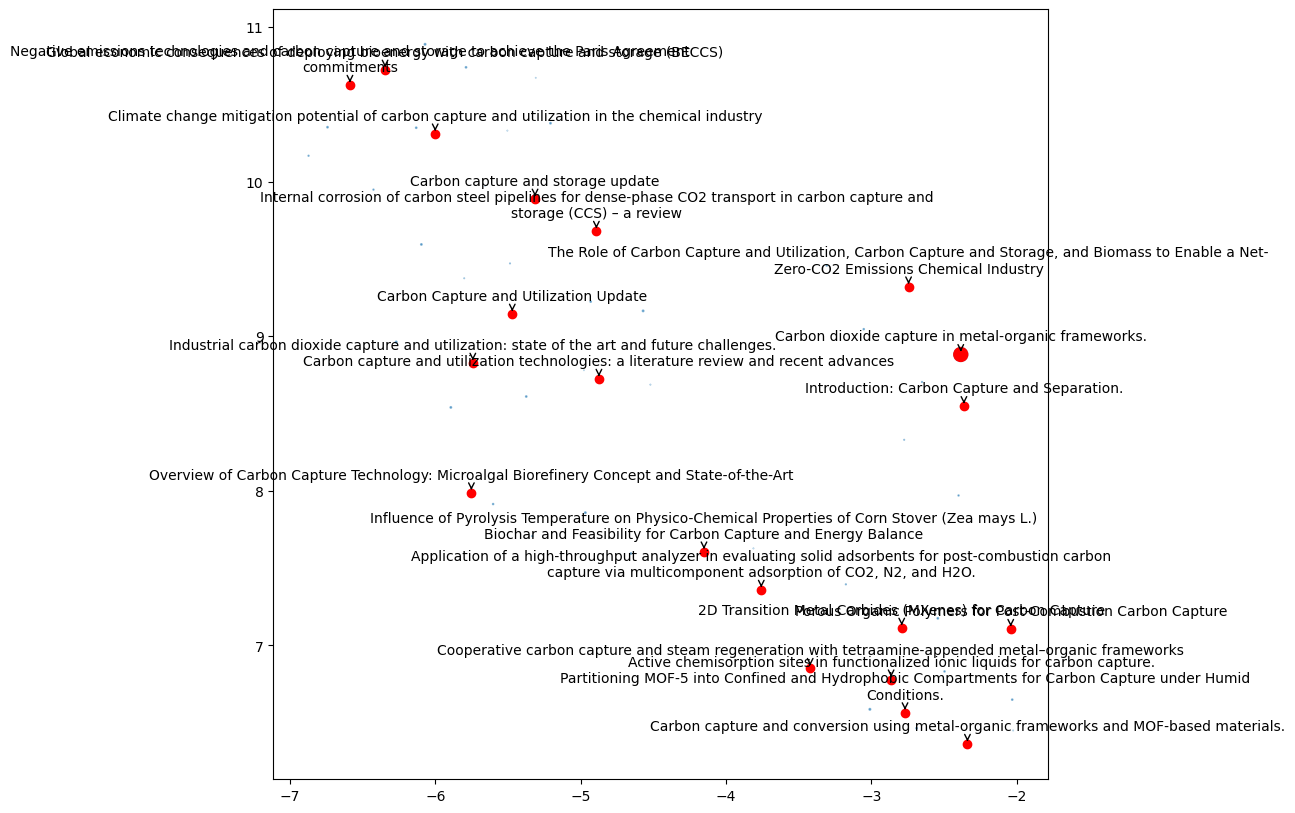

In [149]:
# Add the 2D t-SNE coordinates to the DataFrame and normalize citationCount for node sizes
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]
df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Sort the DataFrame based on citationCount and select the top 20
df_top20 = df.nlargest(20, 'citationCount')

# Create a scatter plot of all the points with node sizes based on normalized citationCount
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red', label='Top 20 papers')

# Prepare to add titles of the top 20 papers to the plot with text wrapping
texts = []
for i, row in df_top20.iterrows():
    title_wrapped = textwrap.fill(row['title'], width=100)  # Wrap text after 20 characters
    plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
    texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

In [152]:
# Exporting dataframe with T-SNE coordinates
df
df.to_json('output_100_umap.json', orient='records')

In [151]:
# # Use adjust_text to automatically adjust the positions of the text labels
# adjust_text(texts)

# plt.title('t-SNE visualization of embedding vectors')
# plt.legend()
# plt.show()

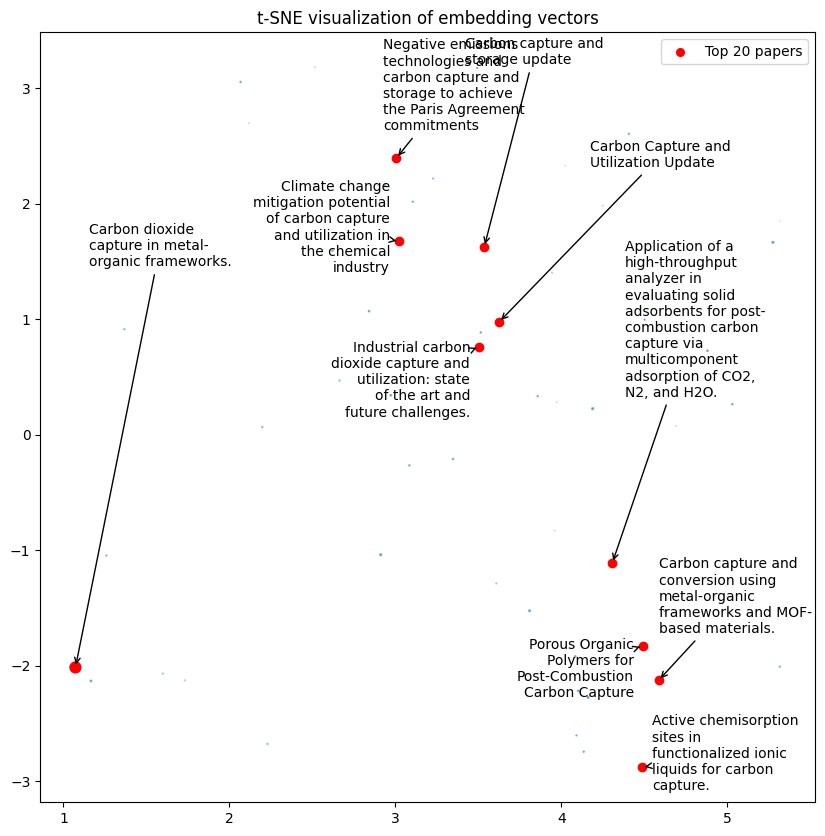

In [ ]:
# # Working implementation of t-SNE?

# # Add the 2D t-SNE coordinates to the DataFrame and normalize citationCount for node sizes
# df['x'] = embeddings_2d[:, 0]
# df['y'] = embeddings_2d[:, 1]
# df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
# df['citationCount_normalized'] = df['citationCount_normalized'] * len(df)  # Scale to a suitable range for scatter plot node sizes

# # Sort the DataFrame based on citationCount and select the top 20
# df_top20 = df.nlargest(10, 'citationCount')

# # Create a scatter plot of all the points with node sizes based on normalized citationCount
# plt.figure(figsize=(10, 10))
# plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# # Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
# top20_scatter = plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red')

# # Prepare to add titles of the top 20 papers to the plot with text wrapping
# texts = []
# for i, row in df_top20.iterrows():
#     title_wrapped = textwrap.fill(row['title'], width=20)  # Wrap text after 20 characters
#     plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
#     texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

# # Use adjust_text to automatically adjust the positions of the text labels
# adjust_text(texts)

# plt.title('t-SNE visualization of embedding vectors')
# plt.legend(handles=[top20_scatter], labels=['Top 20 papers'])
# plt.show()

In [ ]:
# # attempting hierarchical clustering with LDA
# import pandas as pd
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel
# from gensim.utils import simple_preprocess
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Download the set of stop words the first time
# import nltk
# nltk.download('stopwords')

# # Load the set of English stop words
# stop_words = set(stopwords.words('english'))

# # Assume that 'documents' is your list of documents. 
# # Each document is a string of words.

# # Preprocess your documents
# documents = df['abstract'].apply(simple_preprocess)

# # Tokenize the documents into words, convert to lower case, 
# # and remove stop words
# filtered_documents = []
# for doc in documents:
#     word_tokens = doc
#     filtered_document = [word for word in word_tokens if word not in stop_words]
#     filtered_documents.append(filtered_document)

# # Create a gensim dictionary from the documents
# dictionary = Dictionary(filtered_documents)

# # Create a corpus for LDA
# corpus = [dictionary.doc2bow(doc) for doc in documents]

# # Fit an LDA model
# lda = LdaModel(corpus, num_topics=20, id2word=dictionary, alpha='auto', eta='auto')

# # Print the top words for each topic
# for i in range(10):
#     print(f"Topic {i+1}:")
#     print([dictionary[word_id] for word_id, prob in lda.get_topic_terms(i, topn=10)])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1kevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1:
['co', 'capture', 'carbon', 'mof', 'capacity', 'gas', 'adsorption', 'organic', 'metal', 'lca']
Topic 2:
['co', 'capture', 'ccs', 'carbon', 'storage', 'current', 'development', 'technologies', 'potential', 'materials']
Topic 3:
['co', 'carbon', 'capture', 'ccs', 'emissions', 'beccs', 'storage', 'gas', 'climate', 'mof']
Topic 4:
['co', 'capture', 'carbon', 'storage', 'energy', 'system', 'ccs', 'technologies', 'production', 'biomass']
Topic 5:
['co', 'carbon', 'capture', 'ccs', 'gas', 'potential', 'based', 'storage', 'emissions', 'cost']
Topic 6:
['capture', 'co', 'carbon', 'cost', 'ionic', 'liquids', 'containing', 'site', 'chemical', 'global']
Topic 7:
['co', 'carbon', 'capture', 'screening', 'new', 'climate', 'ccs', 'performance', 'materials', 'review']
Topic 8:
['carbon', 'co', 'biomass', 'capture', 'low', 'lca', 'capacity', 'emissions', 'technologies', 'high']
Topic 9:
['co', 'carbon', 'capture', 'gas', 'adsorption', 'corrosion', 'chemical', 'stability', 'emissions', 'based']

In [154]:
# Get the topic-document distribution from the LDA model
topic_dist = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus]

# Convert the topic distributions to a 2D array
topic_dist_array = np.zeros((len(corpus), lda.num_topics))
for i in range(len(corpus)):
    for topic, prob in topic_dist[i]:  # topic_dist[i] is a list of tuples
        topic_dist_array[i, topic] = prob  # topic is an integer (the topic ID)

# Perform hierarchical clustering on the topic-document distribution
cluster = AgglomerativeClustering(n_clusters=5)
cluster_labels = cluster.fit_predict(topic_dist_array)

NameError: name 'corpus' is not defined

In [155]:
print(topic_dist)

NameError: name 'topic_dist' is not defined

In [156]:
# Use t-SNE for visualization
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
embeddings_2d = proj_2d = umap_2d.fit_transform(topic_dist)

# Create a scatter plot of the embeddings, colored by cluster label
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels)
plt.show()

NameError: name 'topic_dist' is not defined

In [ ]:
# Print the top 10 words for each topic
for i in range(lda.num_topics):
    print(f"Topic {i}:")
    for word, prob in lda.show_topic(i, topn=10):
        print(f"  {word}: {prob}")


## Generating Topic Metadata

In [157]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text

In [158]:
df.head()

,paperId,url,title,abstract,year,citationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,embedding,tldr,citations,references,x,y,citationCount_normalized
1,f15a2d21309f429fbec688b8aee5c7bdb66b8f40,https://www.semanticscholar.org/paper/f15a2d21...,Renewable-integrated flexible carbon capture: ...,"To decarbonize electricity grids, CO2 capture ...",2021,28,False,[Environmental Science],"[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [-1.3025...",None,[{'paperId': '0fbc075056e6f013959529ebd322e9c7...,[{'paperId': 'ebceec9a3f0187faf186697ff05450c5...,-5.309471,10.670901,0.097809
5,5b190c555003e154bb9038844899014425236273,https://www.semanticscholar.org/paper/5b190c55...,Carbon capture and conversion using metal-orga...,Rapidly increasing atmospheric CO2 concentrati...,2019,802,False,"[Materials Science, Medicine]","[{'category': 'Materials Science', 'source': '...","{'model': 'specter@v0.1.1', 'vector': [1.39446...","{'model': 'tldr@v2.0.0', 'text': 'This review ...",[{'paperId': '9945477c16dc599782d591b083667130...,[{'paperId': 'a367444fd74633e0b2b1701ed8e6b2c6...,-2.338778,6.361093,15.238654
6,e24d6d882c78389a9c356b87ac46e065087549cf,https://www.semanticscholar.org/paper/e24d6d88...,Climate change mitigation potential of carbon ...,Significance Carbon dioxide (CO2) drives clima...,2019,286,True,"[Medicine, Environmental Science]","[{'category': 'Medicine', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [2.02770...","{'model': 'tldr@v2.0.0', 'text': 'This study s...",[{'paperId': '2733db5f887f33e240477b301c648e82...,[{'paperId': '206fc8a956283c0bd96afdbeaf3d693f...,-6.001421,10.308059,5.144757
8,9496966a27c7a9176ec0a8ff6a04781caa42b7bb,https://www.semanticscholar.org/paper/9496966a...,Cooperative carbon capture and steam regenerat...,Steaming out captured CO2 Although natural gas...,2020,145,False,"[Environmental Science, Medicine]","[{'category': 'Environmental Science', 'source...","{'model': 'specter@v0.1.1', 'vector': [3.92664...","{'model': 'tldr@v2.0.0', 'text': 'A family of ...",[{'paperId': '7ada32ca22cee05761b63611c44f1599...,[{'paperId': 'f4b2e8f3f339a34d29cc37e0f6d68921...,-3.420976,6.851948,2.386541
9,154b9fd69570539e90f51e1b19db944713d3bfdc,https://www.semanticscholar.org/paper/154b9fd6...,A Guideline for Life Cycle Assessment of Carbo...,Carbon Capture and Utilization (CCU) is an eme...,2020,81,True,[Business],"[{'category': 'Business', 'source': 'external'...","{'model': 'specter@v0.1.1', 'vector': [0.53996...",None,[{'paperId': '2964a20a052863f76ab8a6fc862d0ebe...,[{'paperId': 'e24d6d882c78389a9c356b87ac46e065...,-6.096554,9.593366,1.134585


In [159]:
# Trying to

In [160]:
# Collect list of all s2FieldsOfStudy topics, corresponding PaperIds, and citation counts, and the centroid x and y values
import pandas as pd
from collections import defaultdict

# Assuming df is your DataFrame
topic_data = defaultdict(lambda: {"paperIds": [], "citationCount": 0, "xSum": 0, "ySum": 0, "count": 0})

for index, row in df.iterrows():
    for category_info in row['s2FieldsOfStudy']:
        # Get category
        category = category_info['category']
        
        # Prevent duplicates
        if category_info['source'] == 's2-fos-model':
            # Check if paperId already counted for this category
            if row['paperId'] not in topic_data[category]["paperIds"]:
                # Add paper id to category
                topic_data[category]["paperIds"].append(row['paperId'])
            
                # Cumulative citation count
                topic_data[category]["citationCount"] += row['citationCount']
                
                # Sum x and y for the average
                topic_data[category]["xSum"] += row['x']
                topic_data[category]["ySum"] += row['y']
                topic_data[category]["count"] += 1

# Compute the average x and y for each category
for category in topic_data:
    topic_data[category]["x"] = topic_data[category]["xSum"] / topic_data[category]["count"]
    topic_data[category]["y"] = topic_data[category]["ySum"] / topic_data[category]["count"]
    
    # Remove unnecessary keys
    del topic_data[category]["xSum"]
    del topic_data[category]["ySum"]
    del topic_data[category]["count"]

# Convert topic_data to DataFrame
topic_df = pd.DataFrame.from_dict(topic_data, orient='index').reset_index()

# Rename 'index' column to 'Topic'
topic_df.rename(columns={'index': 'topic'}, inplace=True)

In [161]:
topic_df.head()

# Exporting dataframe with T-SNE coordinates
topic_df.to_json('topic_100_umap.json', orient='records')
topic_df


,topic,paperIds,citationCount,x,y
0,Engineering,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, e3e...",894,-4.219830,8.743183
1,Environmental Science,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, e24...",3560,-5.293431,9.398942
2,Chemistry,"[5b190c555003e154bb9038844899014425236273, 625...",1768,-3.404853,7.771949
3,Materials Science,"[9496966a27c7a9176ec0a8ff6a04781caa42b7bb, cfa...",806,-2.936110,7.265545
4,Geology,[76a20bec8e313ced0faf8010e6ecbe3965a9e305],30,-4.520588,8.686763
5,Agricultural And Food Sciences,"[522986777b3989c34f0ea37a35e1c4f4fb3d65c8, f46...",250,-4.763367,8.107574
6,Biology,"[e02f812df3cd677ec931b0ce47e10640f16968fa, ada...",5195,-3.993831,8.398076
7,Economics,"[be026181508eca3fc0ce54bb3571f4fdbc014a8b, 79d...",181,-6.067859,10.729784
8,Business,"[bfd53c8c02171b75dba1ffa1298b59a0b027d298, b12...",96,-5.294699,9.597595
9,Computer Science,"[a747814dc1c674fe172b9bec5315da5fafd57060, 56b...",271,-5.772116,9.099991


In [162]:
# Preprocessing for SPECTRE API
SAMPLE_TOPICS = []

for i, topic in enumerate(topic_data.keys(), start=1):
    topic_dict = {
        "paper_id": topic,
        "title": topic,
        "abstract": topic
    }
    SAMPLE_TOPICS.append(topic_dict)

SAMPLE_TOPICS

[{'paper_id': 'Engineering',
  'title': 'Engineering',
  'abstract': 'Engineering'},
 {'paper_id': 'Environmental Science',
  'title': 'Environmental Science',
  'abstract': 'Environmental Science'},
 {'paper_id': 'Chemistry', 'title': 'Chemistry', 'abstract': 'Chemistry'},
 {'paper_id': 'Materials Science',
  'title': 'Materials Science',
  'abstract': 'Materials Science'},
 {'paper_id': 'Geology', 'title': 'Geology', 'abstract': 'Geology'},
 {'paper_id': 'Agricultural And Food Sciences',
  'title': 'Agricultural And Food Sciences',
  'abstract': 'Agricultural And Food Sciences'},
 {'paper_id': 'Biology', 'title': 'Biology', 'abstract': 'Biology'},
 {'paper_id': 'Economics', 'title': 'Economics', 'abstract': 'Economics'},
 {'paper_id': 'Business', 'title': 'Business', 'abstract': 'Business'},
 {'paper_id': 'Computer Science',
  'title': 'Computer Science',
  'abstract': 'Computer Science'}]

In [163]:
# Need to create SPECTRE em beddings for all the s2FieldsOfStudy
from typing import Dict, List
import json

import requests


URL = "https://model-apis.semanticscholar.org/specter/v1/invoke"
MAX_BATCH_SIZE = 16


def chunks(lst, chunk_size=MAX_BATCH_SIZE):
    """Splits a longer list to respect batch size"""
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]


SAMPLE_PAPERS = [
    {
        "paper_id": "A",
        "title": "Angiotensin-converting enzyme 2 is a functional receptor for the SARS coronavirus",
        "abstract": "Spike (S) proteins of coronaviruses ...",
    },
    {
        "paper_id": "B",
        "title": "Hospital outbreak of Middle East respiratory syndrome coronavirus",
        "abstract": "Between April 1 and May 23, 2013, a total of 23 cases of MERS-CoV ...",
    },
]


def embed(papers):
    embeddings_by_paper_id: Dict[str, List[float]] = {}

    for chunk in chunks(papers):
        # Allow Python requests to convert the data above to JSON
        response = requests.post(URL, json=chunk)

        if response.status_code != 200:
            raise RuntimeError("Sorry, something went wrong, please try later!")

        for paper in response.json()["preds"]:
            embeddings_by_paper_id[paper["paper_id"]] = paper["embedding"]

    return embeddings_by_paper_id


# if __name__ == "__main__":
all_embeddings = embed(SAMPLE_TOPICS)

# Prints { 'A': [4.089589595794678, ...], 'B': [-0.15814849734306335, ...] }
print(len(all_embeddings))
print(len(df['embedding']))

10
59


In [164]:
# Add all_embeddings to new df and then run T-SNE
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text

In [165]:
# Convert all_embeddings values to a list of lists
all_embeddings_list = list(all_embeddings.values())

# Convert df['embedding'] to a list of lists
df_embeddings = df['embedding'].apply(lambda x: x['vector']).tolist()

# Stack them together
combined_embeddings = np.vstack([df_embeddings, all_embeddings_list])

In [166]:
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
embeddings_2d = proj_2d = umap_2d.fit_transform(combined_embeddings)


In [167]:
len(df)

59

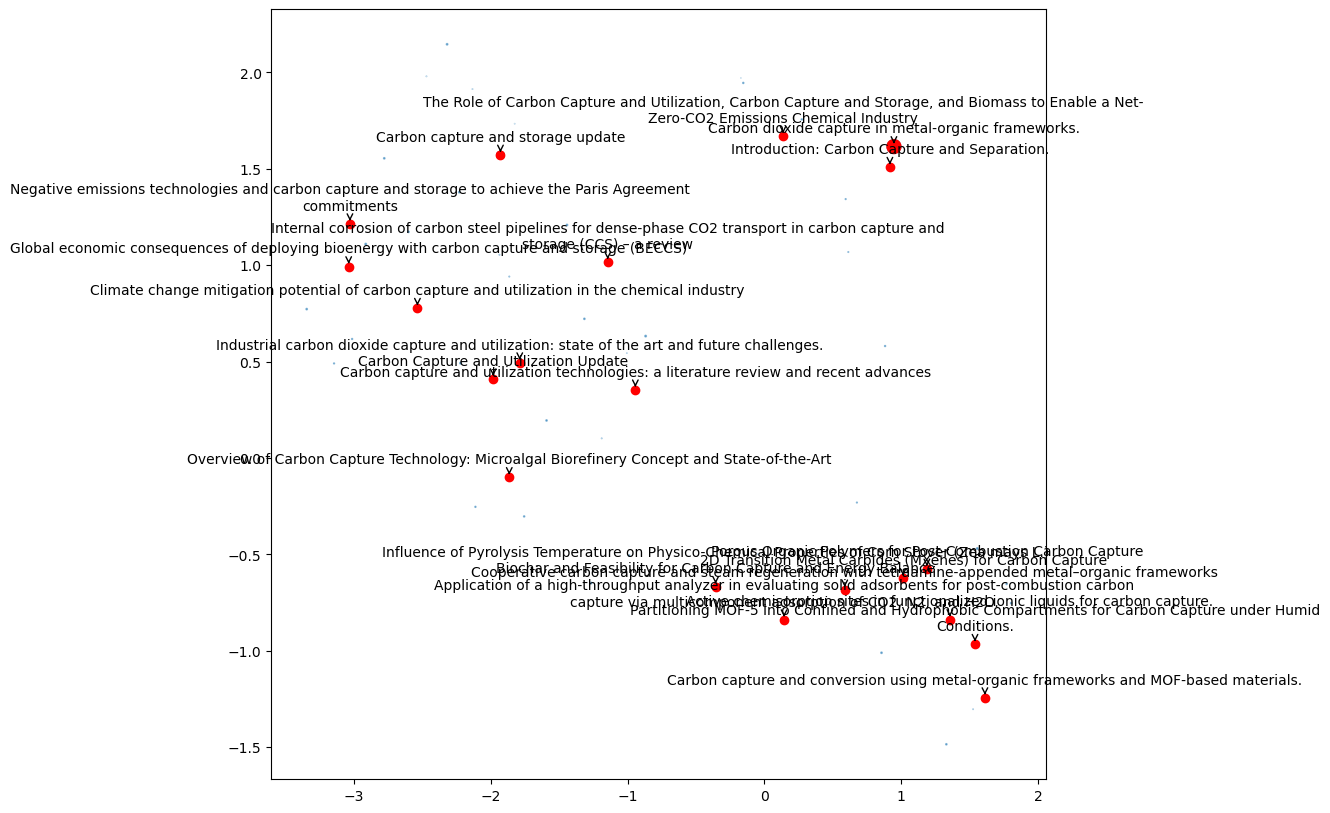

In [168]:
# Add the 2D t-SNE coordinates to the papers DataFrame and normalize citationCount for node sizes
df['x'] = embeddings_2d[:len(df), 0]
df['y'] = embeddings_2d[:len(df), 1]
df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Sort the DataFrame based on citationCount and select the top 20
df_top20 = df.nlargest(20, 'citationCount')

# Create a scatter plot of all the points with node sizes based on normalized citationCount
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red', label='Top 20 papers')

# Prepare to add titles of the top 20 papers to the plot with text wrapping
texts = []
for i, row in df_top20.iterrows():
    title_wrapped = textwrap.fill(row['title'], width=100)  # Wrap text after 20 characters
    plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
    texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

# Exporting dataframe with T-SNE coordinates
df.to_json('output_100_umap.json', orient='records')

In [169]:
# Add x and y coordinates for topics

topic_df['x'] = embeddings_2d[len(df):, 0]
topic_df['y'] = embeddings_2d[len(df):, 1]
# topic_df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
# topic_df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Exporting dataframe with T-SNE coordinates
topic_df.to_json('topic_100_umap.json', orient='records')
topic_df

,topic,paperIds,citationCount,x,y
0,Engineering,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, e3e...",894,11.864798,20.452204
1,Environmental Science,"[f15a2d21309f429fbec688b8aee5c7bdb66b8f40, e24...",3560,11.310593,20.423893
2,Chemistry,"[5b190c555003e154bb9038844899014425236273, 625...",1768,11.356454,20.904434
3,Materials Science,"[9496966a27c7a9176ec0a8ff6a04781caa42b7bb, cfa...",806,11.387806,20.367054
4,Geology,[76a20bec8e313ced0faf8010e6ecbe3965a9e305],30,11.735010,20.376333
5,Agricultural And Food Sciences,"[522986777b3989c34f0ea37a35e1c4f4fb3d65c8, f46...",250,11.143834,20.286352
6,Biology,"[e02f812df3cd677ec931b0ce47e10640f16968fa, ada...",5195,11.348909,20.685556
7,Economics,"[be026181508eca3fc0ce54bb3571f4fdbc014a8b, 79d...",181,11.630734,20.865877
8,Business,"[bfd53c8c02171b75dba1ffa1298b59a0b027d298, b12...",96,11.684353,20.681143
9,Computer Science,"[a747814dc1c674fe172b9bec5315da5fafd57060, 56b...",271,11.665505,20.833195
